# Using the lcvr_learning Class to Measure Training Data

To train our model, it helps to have a large amount of training data. While this can be measured and calibrated by hand, it can take several hours for a single wavelength to get the data. On top of this, changing the orientation of the LCVR's will then change the necessary driving voltage for different polarizations, resulting in prior training data being useless. To combat this, the class has an automated function for collecting training data.

First we need to import the library. In addition, we set the device to our input channel on our ADC module. This is required to know where the data is being read from. We can also set the function generator being used for the square wave as well, which *should* work so long as it follows the same SCPI command syntax as the Siglent 2042x. Otherwise the functions that read and write parameters to the function generators may need to be modified.

In [1]:
import lcvr_learning as lcl
import numpy as np
import pyvisa
import os
import glob
import pandas as pd
import time
import matplotlib.pyplot as plt
rm = pyvisa.ResourceManager('@py')
lcvrs = lcl.lcvr_learning()

There's a few functions in the class that simplify some processes, such as setting the input voltage, getting information on the current inputs, and reading out data from the ADC. This just cuts back a bit on SCPI queries and hopefully makes the code more readable. As an example:

In [17]:
while True:
    print(lcvrs.get_voltage())
    time.sleep(1)

-0.13487500000000008
-0.134859375
-0.1348125
-0.13468750000000007
-0.13456249999999992
-0.13460937499999992
-0.13471875
-0.13479687499999993
-0.13417187500000005
-0.13431250000000006
-0.13429687499999998
-0.134765625
-0.13464062500000007
0.329625
0.3295
0.158421875
-0.3912968750000001
-0.28112500000000007
-0.14160937500000004
-0.39089062499999994
-0.39093749999999994
-0.33885937499999996
-0.13487500000000008
-0.134859375
-0.13468750000000007
-0.134578125
-0.134765625
-0.13456249999999992
0.000109375
9.375e-05
-0.014734375000000188
-0.134578125
-0.13473437500000007
-0.13470312499999992
-0.13453125
-0.13446874999999991


KeyboardInterrupt: 

Returns the current output voltage on the ADC, and

In [2]:
lcvrs.get_wave_info(1)
lcvrs.get_wave_info(2)

(2000.0, 1.0)

Returns the frequency and amplitude of the inputs on channel 1 and 2 respectively. These are initialized to 2000 Hz and 1 V when the connection is made as a safeguard. 

# Automatically Reading and Writing Data:

The class has the function get_training_data(iterations,wavelength), which will automatically alter the input voltages on each LCVR and read the differential output on two photodetectors that are preceeded by a Wollaston prism. This in turn means the output voltage is directly correlated to the polarization state of the output light. All of this data is then written to a pandas dataframe for easy manipulation.

In [7]:
data = lcvrs.get_training_data(375,480,mode = "fixed_v1", v1 = 4.8581)

Starting training data scan. Don't touch anything please


In [5]:
data.head()

,Wavelength,V1,V2,Gain,Out
0,480,4.8581,0.600000,1,-0.033141
1,480,4.8581,0.647236,1,0.013000
2,480,4.8581,0.694472,1,0.072953
3,480,4.8581,0.741709,1,0.126484
4,480,4.8581,0.788945,1,0.127062


Here we write the data to a .csv file to train our model on later. The name is simply the wavelength of light used (in nm) to try and keep things readable.

In [8]:
data.to_csv('training_data/single_wave/480_single_v1.csv')

# Fitting 3D V1, V2, Angle Data to a Fixed V1 with Full Polarization Range

For a single wavelength, we can reduce the problem to simply a single fixed V1 axis where any arbitrary polarization angle is achievable. However, we first need to find this axis, then apply the fit to get reliable predictions. This is also handled in the lcvr_learning file within the optimize_model class.

First, pick the data we'd like to use. Here I'm going to combine all the data from the single_wave file since it's just multiple measurements at a fixed wavelength. Also adding the angle column because at the time of measurement it was not automatically added for this data.

In [4]:
data_dir = 'training_data/single_wave/'
all_data = glob.glob(os.path.join(data_dir, "*.csv"))
combined_data = pd.concat([pd.read_csv(file) for file in all_data], ignore_index=True)
combined_data = lcvrs.add_angle(combined_data)

Now we need to find the axis for which we'll get the total range of polarization angles at a fixed V1

In [2]:
fit_data_2d = pd.read_csv('training_data/single_wave/single_wave_2d_high_delay.csv')

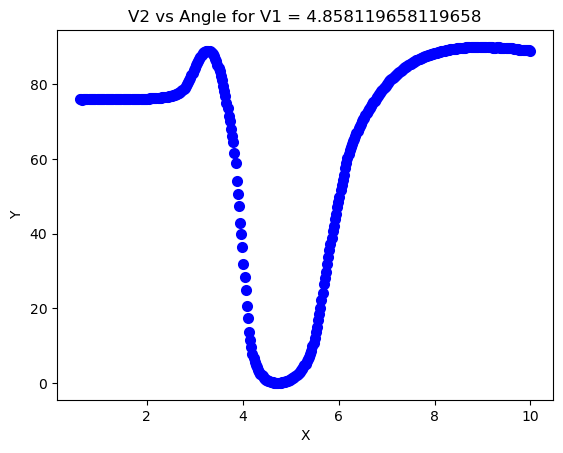

In [3]:
x2d = fit_data_2d['V2']
y2d = fit_data_2d['Angle']

fig, ax = plt.subplots()

ax.scatter(x2d, y2d, color='blue', linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('V2 vs Angle for V1 = ' + str(fit_data_2d['V1'][2]))

plt.show()

Now create an optimize_model class with this data

In [4]:
v1 = fit_data_2d['V1'][2]
model_fit = lcl.optimize_model(fit_data_2d)

Now find the best c, gamma parameters (hyperparamters) for the svm fit. This can take a few minutes. There may be room for future optimization here, but since it's currently about a 5 minute process on the raspberry pi (that's performed once), it's not a top priority.

In [5]:
fit_c, fit_gamma = model_fit.optimize_model_2d()

Loop: 300 20
Loop: 244.44444444444446 18.0
Loop: 300.0 16.0
Loop: 272.22222222222223 15.0
Loop: 291.6666666666667 14.5
Loop: 304.1666666666667 14.25
Loop: 310.4166666666667 14.125
Loop: 312.84722222222223 14.0625
Loop: 311.28472222222223 14.0
Loop: 312.06597222222223 13.9375


Here fit_c, fit_gamma around 312.066, 13.94

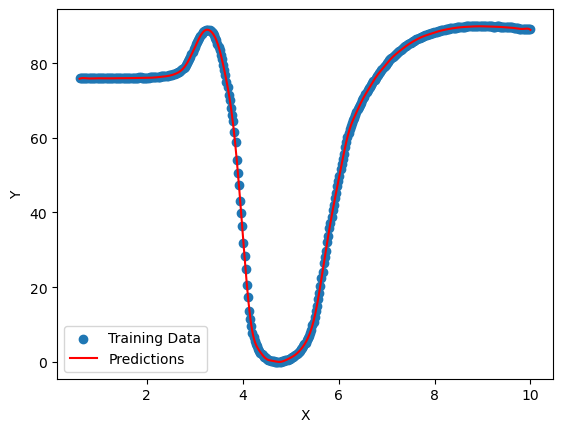

In [5]:
model = model_fit.fit_2d(312.066,13.94)
x_model = np.linspace(0.6, 10, 500).reshape(-1, 1)
y_model = model.predict(x_model)

# Plotting
plt.scatter(x2d, y2d, label='Training Data') 
plt.plot(x_model, y_model, color='red', label='Predictions') 
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Now with the fitted model we can calculate the rmse directly. We take randomly selected V2's and compare the measurement with the prediction in real time, then get the RMSE

In [6]:
lcvrs.close_connection()
scale, range, offset = model_fit.get_scale(fit_data_2d)
rmse = model_fit.calc_rmse(model,250,v1,scale,range,offset)

In [8]:
rmse[0]

0.30143136546748434

Very low error!

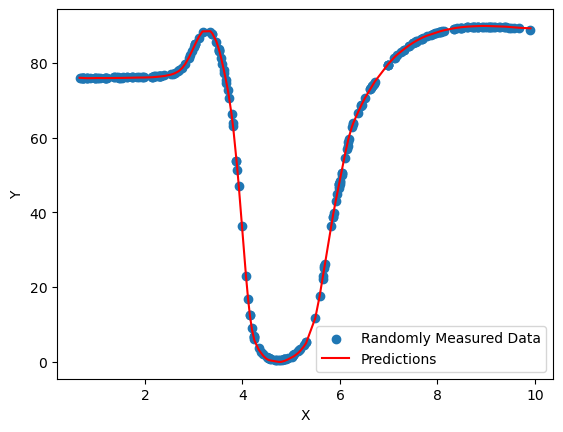

In [10]:
y_meas = rmse[1][1]
y_pred = rmse[1][2]

# Plotting
plt.scatter(rmse[1][0], y_meas, label='Randomly Measured Data') 
plt.plot(rmse[1][0], y_pred, color='red', label='Predictions') 
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Entire Process Automated with complete_fit_2d

The lcvr_learning library also contains a class to perform this whole process automatically, called complete_fit_2d. It will store the 3d training data in the 'training_data/temp' folder in case it's wanted, but otherwise completes the whole process start to finish with no input. At the end it returns the 2D model with best RMSE.

Note: with num_measurements at 500 and val_meas at 300 with 5 models it took about 80 minutes to run. Will probably work to cut this time down. That said, the majority of the time was spent comparing models, so just taking the max and scanning is much faster

In [2]:
lcvrs.close_connection()

In [3]:
modeller = lcl.complete_fit_2d(123,num_measurements=200,val_meas=300,num_models=5)

In [4]:
model = modeller.get_2d_model()

Starting training data scan. Don't touch anything please
Finding optimal V1
Rescanning along new axis
Starting training data scan. Don't touch anything please
Rescanning along new axis
Starting training data scan. Don't touch anything please
Rescanning along new axis
Starting training data scan. Don't touch anything please
Rescanning along new axis
Starting training data scan. Don't touch anything please
Optimizing 2D Model #0
Loop: 300 20
Loop: 311.1111111111111 18.0
Loop: 211.1111111111111 16.0
Loop: 261.1111111111111 15.0
Loop: 286.1111111111111 14.5
Loop: 298.6111111111111 14.25
Loop: 292.3611111111111 14.125
Loop: 294.79166666666663 14.0625
Loop: 293.22916666666663 14.0
Loop: 294.01041666666663 13.9375
Optimizing 2D Model #1
Loop: 300 20
Loop: 200.0 18.0
Loop: 300.0 16.0
Loop: 350.0 15.0
Loop: 352.77777777777777 14.5
Loop: 354.1666666666667 14.25
Loop: 353.47222222222223 14.125
Loop: 355.2083333333333 14.0625
Loop: 354.34027777777777 14.0
Loop: 353.73263888888886 13.9375
Optimizin

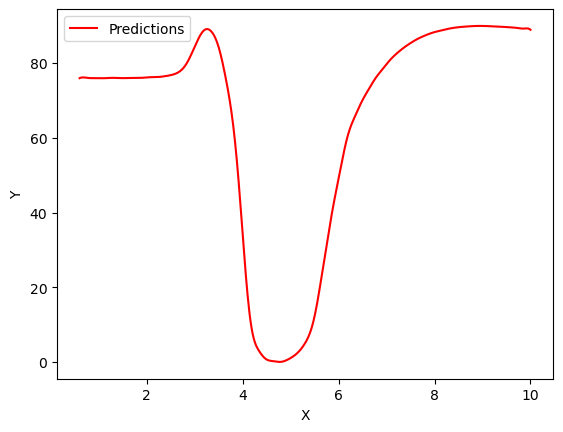

In [5]:
x_model = np.linspace(0.6, 10, 500).reshape(-1, 1)
y_model = model.predict(x_model)

# Plotting
plt.plot(x_model, y_model, color='red', label='Predictions') 
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()